## Exploratory analysis

In [1]:
# #Optional: run analysis on subset of dataset
# search = 'dieren|natuur|natura|CO2|milieuklimaat|biodiversiteit'
# print(df['Text'].str.contains(search).sum())
# df = df.loc[df['Text'].str.contains(search)]
# df = (df.loc[df['Topic'].isin([23,27,21,20,8])])
# 1+1

In [2]:
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import altair as alt
import pandas as pd
from collections import Counter

In [3]:
import pickle
file = open("moties_processed_df.pickle","rb")
df = pickle.load(file)
print(len(df))

column_list = df.columns.values
indiener_column = [c for c in column_list if 'Indiener' in c]
medeindiener_column = [c for c in column_list if 'Medeindiener' in c]
stem_column = [c for c in column_list if 'Stem_' in c]
aantal_stemmen_column = [c for c in column_list if 'Aantal' in c]

29514


In [4]:
def get_largest_parties(year=2020,top=False):
    tmp = df[(df['Vergaderjaar']==str(year)+'-'+str(year+1))]
    parties = [p for p in tmp.columns if 'Aantal_stemmen' in p][1:]
    tmp = tmp[parties].mean().sort_values(ascending=False)
    tmp = tmp[tmp.notna()]
    tmp.index = tmp.index.str[15:]
    if top: return tmp[:top].index
    else: return tmp.index

def to_vergaderjaar(year):
    return str(year) + '-' + str(year+1)
    
get_largest_parties(2020)

Index(['VVD', 'PVV', 'D66', 'CDA', 'SP', 'GroenLinks', 'PvdA', 'ChristenUnie',
       'PvdD', 'SGP', 'DENK', 'FvD', 'Van Kooten-Arissen', 'Van Haga', 'Krol'],
      dtype='object')

In [57]:
from collections import namedtuple
import datetime
Cabinet = namedtuple('Cabinet', ['name','start', 'end', 'demissionair','coalition'])
Chamber = namedtuple('Chamber', ['name','start', 'end', 'numyears'])

chamber_input = [
    "Balkenende IV,01 01 2009,16 06 2010",# mark begin 2008 is not correct (should be 30 11 2006) but for dataset purpose it it
    "Rutte I,17 06 2010,19 09 2012",
    "Rutte II,20 09 2012,22 03 2017",
    "Rutte III,23 03 2017,31 12 2020"] # mark end 2020 is not correct but for dataset purpose it it

chambers = {}
for c in chamber_input:
    c = c.split(',')
    name = c[0]
    start = list(map(int, c[1].split()))
    startdate = datetime.datetime(start[2], start[1], start[0])
    end = list(map(int, c[2].split()))
    enddate = datetime.datetime(end[2], end[1], end[0])
    numyears = (enddate - startdate).days/365
    chambers[name] = Chamber(name, startdate, enddate, numyears)


cabinets_input = [
    # "Balkenende III,07 07 2006,22 02 2007,CDA VVD",
    # "Balkenende IV,22 02 2007,14 10 2010,CDA PvdA ChristenUnie",
    "Balkenende IV,18 09 2008,14 10 2010,20 02 2010,CDA PvdA ChristenUnie",
    "Rutte I,14 10 2010,5 11 2012,23 04 2012,VVD CDA PVV",
    "Rutte II,5 11 2012,26 10 2017,14 03 2017,VVD PvdA",
    "Rutte III,26 10 2017,15 01 2022,15 01 2022,CDA VVD D66 ChristenUnie"]

cabinets = {}
for c in cabinets_input:
    c = c.split(',')
    name = c[0]
    start = list(map(int, c[1].split()))
    startdate = datetime.datetime(start[2], start[1], start[0])
    end = list(map(int, c[2].split()))
    enddate = datetime.datetime(end[2], end[1], end[0])
    coalition = tuple(c[3].split())
    cabinets[name] = Cabinet(name, startdate, enddate, numyears, coalition)
cabinets, chambers

{'Balkenende IV': Cabinet(name='Balkenende IV', start=datetime.datetime(2008, 9, 18, 0, 0), end=datetime.datetime(2010, 10, 14, 0, 0), demissionair=3.778082191780822, coalition=('20', '02', '2010')),
 'Rutte I': Cabinet(name='Rutte I', start=datetime.datetime(2010, 10, 14, 0, 0), end=datetime.datetime(2012, 11, 5, 0, 0), demissionair=3.778082191780822, coalition=('23', '04', '2012')),
 'Rutte II': Cabinet(name='Rutte II', start=datetime.datetime(2012, 11, 5, 0, 0), end=datetime.datetime(2017, 10, 26, 0, 0), demissionair=3.778082191780822, coalition=('14', '03', '2017')),
 'Rutte III': Cabinet(name='Rutte III', start=datetime.datetime(2017, 10, 26, 0, 0), end=datetime.datetime(2022, 1, 15, 0, 0), demissionair=3.778082191780822, coalition=('15', '01', '2022'))}

In [56]:
chambers

{'Balkenende IV': Chamber(name='Balkenende IV', start=datetime.datetime(2006, 11, 30, 0, 0), end=datetime.datetime(2010, 6, 16, 0, 0), numyears=3.5452054794520547),
 'Rutte I': Chamber(name='Rutte I', start=datetime.datetime(2010, 6, 17, 0, 0), end=datetime.datetime(2012, 9, 19, 0, 0), numyears=2.26027397260274),
 'Rutte II': Chamber(name='Rutte II', start=datetime.datetime(2012, 9, 20, 0, 0), end=datetime.datetime(2017, 3, 22, 0, 0), numyears=4.504109589041096),
 'Rutte III': Chamber(name='Rutte III', start=datetime.datetime(2017, 3, 23, 0, 0), end=datetime.datetime(2020, 12, 31, 0, 0), numyears=3.778082191780822)}

## Ontwikkeling van het aantal moties

In [8]:
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Titel', 'count')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})
color_order = {'Afgewezen':1, 'Aangenomen':0}
data["idx"] = data["BesluitSoort"].map(color_order)

alt.Chart(data, width=400,height = 150).mark_bar().encode(
    x=alt.X('Jaar:N'),
    y='Aantal:Q',
    order="idx",
    color=alt.Color('BesluitSoort',
                   scale=alt.Scale(
            domain=['Aangenomen','Afgewezen'],
            range=['green', 'red']))
)

alt.Chart(...)

We onderzoeken alle aangenomen moties tussen 2009 en 2020. In totaal is er over bijna 30.000 moties gestemd. Het aantal moties stijgt, en met name het aantal aangenomen moties. In verkiezingsjaren (2010, 2012 en 2017) ligt het aantal moties duidelijk lager. Tussen 2012 en 2013 werden relatief veel moties afgewezen.

In [6]:
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Voor', 'mean')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})

# source = source.melt('index',var_name='Stem', value_name='Gemiddeld aantal voorstemmen')
# source['index'] += 2008
chart = alt.Chart(data,width=400,height = 150).mark_line().encode(
    x=alt.X('Jaar:N', axis=alt.Axis(title='Jaar')),
    y='Aantal:Q',
    color=alt.Color('BesluitSoort:N',
                scale=alt.Scale(
        domain=['Aangenomen','Afgewezen'],
        range=['green', 'red']))

)
chart.encoding.y.title = 'Aantal voorstemmen'
chart

alt.Chart(...)

Moties die worden aangenomen halen meestal rond de 120. Moties die het niet halen blijven meestal rond de 50 stemmen hangen. Eigenlijk zegt zo'n gemiddelde niet zoveel en kan je beter naar de verdeling van het aantal voorstemmen kijken, dat doen we nu met een histogram per kabinetsperiode.

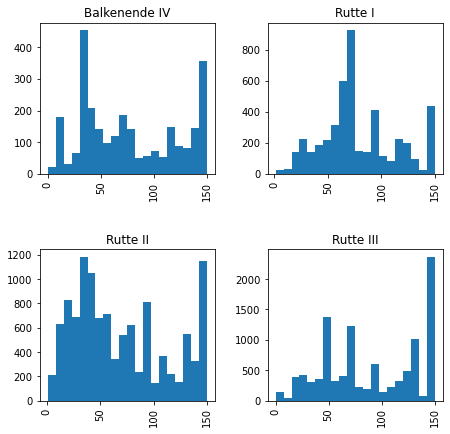

In [50]:
df['Voor'].hist(by=df['Kabinet'], bins=20, figsize=(7,7));

In bovenstaande histogrammen gaat het vooral om de verdeling van de moties. Het absolute aantal is niet echt vergelijkbaar omdat de duur van de kabinetten verschillend is. 
* Bij Balkenende IV zijn meerdere pieken te zien: protestmoties die nauwelijks stemmen krijgen, een grote piek met moties die rond de 35 stemmen blijven hangen en een piek met unaniem aangenomen moties
* Bij Rutte I waren er relatief veel meer moties die het nipt wel of juist niet haalden.
* Bij Rutte II is verlijkbaar met Balkenende IV, behalve dat er meer moties het niet haalden
* Bij Rutte III is er een hele grote piek in het aantal unaniem aangenomen moties. Dit lijken er ook steeds meer te worden (500 in 2018, 700 in 2019 en 900 in 2020)

In [47]:
medeindieners = df['Medeindiener_persoon'].values
c = Counter(len(i) for i in medeindieners)
c.most_common()
source = pd.DataFrame(c.most_common()).rename(columns={0:'Aantal medeindieners',1:'Aantal moties'})
alt.Chart(source,width=400,height = 150).mark_bar().encode(
    x=alt.X('Aantal medeindieners:O',sort=alt.EncodingSortField(field="x", op="count", order='ascending')),
    y='Aantal moties:Q'
)

alt.Chart(...)

Meestal worden moties ingediend door 1 partij, maar soms zijn er medeindieners. Sinds 2008 is er [één special snowflake motie](https://www.tweedekamer.nl/kamerstukken/detail?id=2020Z20755&did=2020D44509), met maar liefst 16 medeindieners. Van harte Dion Graus!

## Komt elke partij opdagen?

In [20]:
# how many percent of moties did parties vote. Conclusion almost all
nan_per_party = df[stem_column].isnull().groupby([df['Kabinet']]).sum(axis=0)
count_per_cabinet = df.groupby(['Kabinet']).count()['Titel']
relevant_parties = ['Stem_'+p for p in get_largest_parties(2020)]
1- np.divide(nan_per_party, count_per_cabinet.values[:,None])[relevant_parties]

,Stem_VVD,Stem_PVV,Stem_D66,Stem_CDA,Stem_SP,Stem_GroenLinks,Stem_PvdA,Stem_ChristenUnie,Stem_PvdD,Stem_SGP,Stem_DENK,Stem_FvD,Stem_Van Kooten-Arissen,Stem_Van Haga,Stem_Krol
Kabinet,,,,,,,,,,,,,,,
Balkenende IV,1.000000,0.986652,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999629,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rutte I,0.999787,1.000000,1.000000,1.000000,1.000000,0.999787,0.999787,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rutte II,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.070082,0.069558,0.000000,0.000000,0.000000
Rutte III,0.997751,0.997751,0.997751,0.997751,0.997751,0.997751,0.997751,0.997751,0.997657,0.997751,0.996158,0.976574,0.365161,0.381466,0.157515


In [42]:
relevant_parties = ['Aantal_stemmen_'+p for p in get_largest_parties(2020)]
mean_votes_per_party = df.replace(np.nan, 0).groupby('Kabinet').mean()[relevant_parties]
max_votes_per_party = df.groupby('Kabinet').max()[relevant_parties]
np.divide(mean_votes_per_party, max_votes_per_party.values)

,Aantal_stemmen_VVD,Aantal_stemmen_PVV,Aantal_stemmen_D66,Aantal_stemmen_CDA,Aantal_stemmen_SP,Aantal_stemmen_GroenLinks,Aantal_stemmen_PvdA,Aantal_stemmen_ChristenUnie,Aantal_stemmen_PvdD,Aantal_stemmen_SGP,Aantal_stemmen_DENK,Aantal_stemmen_FvD,Aantal_stemmen_Van Kooten-Arissen,Aantal_stemmen_Van Haga,Aantal_stemmen_Krol
Kabinet,,,,,,,,,,,,,,,
Balkenende IV,0.526855,0.409714,0.287264,0.968818,0.974490,0.718910,0.863464,0.989371,0.999629,0.666790,NaN,NaN,NaN,NaN,NaN
Rutte I,0.761088,0.979669,0.836854,0.991953,1.000000,0.986751,0.793752,1.000000,1.000000,0.673707,NaN,NaN,NaN,NaN,NaN
Rutte II,0.974109,0.665059,0.657325,0.706342,0.995328,0.335773,0.915506,1.000000,0.442049,1.000000,0.070082,0.069558,NaN,NaN,NaN
Rutte III,0.983982,0.995610,0.997751,0.997751,0.997751,0.997751,0.997751,0.997751,0.904573,0.997751,0.996158,0.976574,0.365161,0.381466,0.157515


In [43]:
mean_votes_per_party

,Aantal_stemmen_VVD,Aantal_stemmen_PVV,Aantal_stemmen_D66,Aantal_stemmen_CDA,Aantal_stemmen_SP,Aantal_stemmen_GroenLinks,Aantal_stemmen_PvdA,Aantal_stemmen_ChristenUnie,Aantal_stemmen_PvdD,Aantal_stemmen_SGP,Aantal_stemmen_DENK,Aantal_stemmen_FvD,Aantal_stemmen_Van Kooten-Arissen,Aantal_stemmen_Van Haga,Aantal_stemmen_Krol
Kabinet,,,,,,,,,,,,,,,
Balkenende IV,21.601038,9.833148,3.447164,39.721542,24.362254,7.189099,32.811643,5.936225,1.999258,2.000371,0.000000,0.000000,0.000000,0.000000,0.000000
Rutte I,31.204608,23.512055,10.042245,20.831022,15.000000,9.867506,30.162577,5.000000,2.000000,2.021122,0.000000,0.000000,0.000000,0.000000,0.000000
Rutte II,39.938471,13.301187,12.489178,13.420492,14.929918,4.700820,34.789230,5.000000,2.210246,3.000000,0.210246,0.139117,0.000000,0.000000,0.000000
Rutte III,32.471421,19.912200,18.957271,18.957271,13.968516,13.968516,8.979760,4.988756,4.522864,2.993253,2.988475,1.953148,0.365161,0.381466,0.157515


In [44]:
df.groupby('Kabinet').max()[relevant_parties]

,Aantal_stemmen_VVD,Aantal_stemmen_PVV,Aantal_stemmen_D66,Aantal_stemmen_CDA,Aantal_stemmen_SP,Aantal_stemmen_GroenLinks,Aantal_stemmen_PvdA,Aantal_stemmen_ChristenUnie,Aantal_stemmen_PvdD,Aantal_stemmen_SGP,Aantal_stemmen_DENK,Aantal_stemmen_FvD,Aantal_stemmen_Van Kooten-Arissen,Aantal_stemmen_Van Haga,Aantal_stemmen_Krol
Kabinet,,,,,,,,,,,,,,,
Balkenende IV,41.0,24.0,12.0,41.0,25.0,10.0,38.0,6.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN
Rutte I,41.0,24.0,12.0,21.0,15.0,10.0,38.0,5.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN
Rutte II,41.0,20.0,19.0,19.0,15.0,14.0,38.0,5.0,5.0,3.0,3.0,2.0,NaN,NaN,NaN
Rutte III,33.0,20.0,19.0,19.0,14.0,14.0,9.0,5.0,5.0,3.0,3.0,2.0,1.0,1.0,1.0


In [45]:
df.groupby('Kabinet').median()[relevant_parties]

,Aantal_stemmen_VVD,Aantal_stemmen_PVV,Aantal_stemmen_D66,Aantal_stemmen_CDA,Aantal_stemmen_SP,Aantal_stemmen_GroenLinks,Aantal_stemmen_PvdA,Aantal_stemmen_ChristenUnie,Aantal_stemmen_PvdD,Aantal_stemmen_SGP,Aantal_stemmen_DENK,Aantal_stemmen_FvD,Aantal_stemmen_Van Kooten-Arissen,Aantal_stemmen_Van Haga,Aantal_stemmen_Krol
Kabinet,,,,,,,,,,,,,,,
Balkenende IV,21.0,9.0,3.0,41.0,25.0,7.0,33.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
Rutte I,31.0,24.0,10.0,21.0,15.0,10.0,30.0,5.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
Rutte II,40.0,12.0,12.0,13.0,15.0,4.0,36.0,5.0,2.0,3.0,3.0,2.0,NaN,NaN,NaN
Rutte III,33.0,20.0,19.0,19.0,14.0,14.0,9.0,5.0,5.0,3.0,3.0,2.0,1.0,1.0,1.0


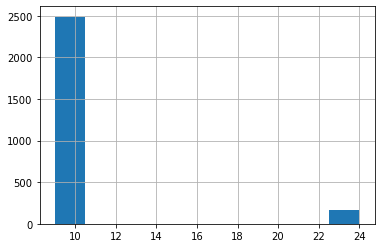

In [46]:
df[df['Kabinet']=='Balkenende IV']['Aantal_stemmen_PVV'].hist()

In [52]:
df[(df['Kabinet']=='Balkenende IV') & (df['Aantal_stemmen_PVV'] == 24)]

,Titel,AgendapuntOnderwerp,Onderwerp,Datum,GestartOp,Vergaderjaar,Kabinet,StemmingsSoort,BesluitSoort,BesluitTekst,...,Stem_PvdD,Stem_SGP,Stem_SP,Stem_VVD,Stem_Van Haga,Stem_Van Klaveren,Stem_Van Kooten-Arissen,Stem_Van Vliet,Stem_Verdonk,Jaar
2010Z06296,Prenatale screening,Stemming over: aangehouden motie ingediend bij...,Motie-Langkamp/Arib over een EHBO-certificaat ...,2010-04-08 00:00:00+02:00,2010-04-08T00:00:00+02:00,2009-2010,Balkenende IV,Met handopsteken,1,Aangenomen,...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2010
2010Z06641,Voorstel van wet van de leden Koser Kaya en Bl...,Stemming over: motie ingediend bij Voorstel va...,Motie Omtzigt c.s. over modernisering van de g...,2010-04-13 00:00:00+02:00,2010-04-13T00:00:00+02:00,2009-2010,Balkenende IV,Met handopsteken,1,Aangenomen,...,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2010
2010Z09761,Vaststelling van de begrotingsstaat van het In...,Stemmingen over: moties ingediend bij het VAO ...,Motie Wiegman-van Meppelen Scheppink en Van Ge...,2010-06-23 00:00:00+02:00,2010-06-23T00:00:00+02:00,2009-2010,Balkenende IV,Met handopsteken,0,Verworpen,...,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2010
2010Z09779,Vaststelling van de begrotingsstaat van het In...,Stemmingen over: moties ingediend bij het VAO ...,Motie Neppérus en Aptroot over een duurzame va...,2010-06-23 00:00:00+02:00,2010-06-23T00:00:00+02:00,2009-2010,Balkenende IV,Met handopsteken,1,Aangenomen,...,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2010
2010Z09776,Vaststelling van de begrotingsstaat van het In...,Stemmingen over: moties ingediend bij het VAO ...,Motie De Rouwe c.s. over een permanent karakte...,2010-06-23 00:00:00+02:00,2010-06-23T00:00:00+02:00,2009-2010,Balkenende IV,Met handopsteken,1,Aangenomen,...,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010Z14707,Internationale klimaatafspraken,Stemmingen over: moties ingediend bij het VAO ...,Gew. motie Neppérus over het uitvoeren van de ...,2010-10-13 00:00:00+02:00,2010-10-13T00:00:00+02:00,2010-2011,Balkenende IV,Met handopsteken,1,Aangenomen,...,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2010
2010Z14699,Internationale klimaatafspraken,Stemmingen over: moties ingediend bij het VAO ...,Motie Van Bemmel en De Mos over een vertrek va...,2010-10-13 00:00:00+02:00,2010-10-13T00:00:00+02:00,2010-2011,Balkenende IV,Met handopsteken,0,Verworpen,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2010
2010Z14675,Uitvoering Wet Werk en Bijstand,Stemmingen over: moties ingediend bij het VAO ...,Gew motie Karabulut c.s. over de gevolgen van ...,2010-10-13 00:00:00+02:00,2010-10-13T00:00:00+02:00,2010-2011,Balkenende IV,Met handopsteken,0,Verworpen,...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2010
2010Z14698,Internationale klimaatafspraken,Stemmingen over: moties ingediend bij het VAO ...,Motie Van Veldhoven c.s. over pleiten voor een...,2010-10-13 00:00:00+02:00,2010-10-13T00:00:00+02:00,2010-2011,Balkenende IV,Met handopsteken,0,Verworpen,...,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2010


### Van Koorten en de Bie: Welke partij is de 'tegenpartij'?

In [12]:
startjaar = 2020
data = df.groupby(['Kabinet']).mean()[['Stem_'+p for p in get_largest_parties(startjaar,12)]]
data = data.reset_index()
data = data.melt('Kabinet',var_name='Stem', value_name='Stemgedrag')

alt.Chart(data,width=600).mark_line().encode(
    x='Kabinet:N',
    y=alt.Y('Stemgedrag:Q'),
    color='Stem:N',
)

alt.Chart(...)

VVD (oranje) stemt het meeste tegen. Waarschijnlijk omdat de meeste moties gericht zijn aan de regering en de VVD eigenlijk altijd regeert

## Welke partijen dienen het meeste moties in en hoe succesvol zijn ze?

In [14]:
def get_summary_stats(df):
    df = df.dropna(axis='columns',how='all')
    indiener_column = [c for c in df.columns if 'Indiener' in c]
    indiener = {p:p[9:] for p in indiener_column}
    df = df.rename(indiener,axis=1)
    largest_parties = get_largest_parties(2020,12)
    indiener_column = [i for i in indiener.values() if i in largest_parties]
    aantal_stemmen_column = [c for c in df.columns if 'Aantal_stemmen' in c]
      
    success_rate = np.multiply(df[indiener_column],df['BesluitSoort'][:, np.newaxis]).mean(axis=0).sort_index()
    success_rate = success_rate[success_rate.notna()]
    aantal_moties = df[indiener_column].sum().sort_index()
    aantal_moties = aantal_moties[aantal_moties.notna()]
    aantal_succesvolle_moties = np.multiply(success_rate,aantal_moties)
    aantal_succesvolle_moties = aantal_succesvolle_moties[aantal_succesvolle_moties.notna()]
    aantal_niet_succesvolle_moties = np.multiply((1-success_rate),aantal_moties)
    aantal_niet_succesvolle_moties = aantal_niet_succesvolle_moties[aantal_niet_succesvolle_moties.notna()]
    aantal_zetels = df[aantal_stemmen_column].mean()
    aantal_zetels = aantal_zetels[['Aantal_stemmen_'+p for p in aantal_moties.index]]
    aantal_zetels.index = aantal_moties.index
    aantal_zetels = aantal_zetels[aantal_zetels.notna()]
    aantal_zetels.index = aantal_moties.index
    aantal_moties_zetel = np.divide(aantal_moties,aantal_zetels)
    aantal_succesvolle_moties_zetel = np.divide(aantal_succesvolle_moties,aantal_zetels)
    aantal_niet_succesvolle_moties_zetel = np.divide((aantal_moties-aantal_succesvolle_moties),aantal_zetels)
    return success_rate,aantal_moties,aantal_succesvolle_moties,aantal_niet_succesvolle_moties, aantal_zetels, aantal_moties_zetel,aantal_succesvolle_moties_zetel,aantal_niet_succesvolle_moties_zetel

party_perf = pd.DataFrame({})
res_columns = ['success_rate','aantal_moties','aantal_succesvolle_moties','aantal_niet_succesvolle_moties', 'aantal_zetels', 'aantal_moties_zetel','aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel']
for k in df['Kabinet'].unique():
    result = get_summary_stats(df.loc[df['Kabinet'] == k])
    for i,res in enumerate(result):
        df_temp = pd.DataFrame(res).reset_index()
        df_temp['stat']=res_columns[i]
        df_temp['kabinet']= k
        party_perf = party_perf.append(df_temp, ignore_index = True)
# for start_year in range(year,2020):
#     result = get_summary_stats(start_year,df.loc[df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1)])
#     for i,res in enumerate(result):
#         df_temp = pd.DataFrame(res).reset_index()
#         df_temp['stat']=res_columns[i]
#         df_temp['year']=str(start_year)+'-'+str(start_year+1)
#         party_perf = party_perf.append(df_temp, ignore_index = True)
party_perf = party_perf.rename({'index':'partij',0:'value'},axis=1)

In [15]:
# normalize metrics starting with 'aantal' to account for length of ca
mask = party_perf['stat'].str.contains('aantal')
valid = party_perf[mask]
party_perf.loc[mask, 'value'] = valid['value'] / valid['kabinet'].map(lambda x: cabinets[x].numyears)

In [127]:
# Step 1: create the line
metric_of_interest = 'aantal_succesvolle_moties_zetel'
data = party_perf[party_perf['stat'] == metric_of_interest]
data['partij'] = pd.Categorical(data['partij'], parties)
data = data.sort_values("partij")
# https://imagecolorpicker.com/
party_colors = {
'CDA':'#5cb957',
 'ChristenUnie':'#00a5e8',
 'D66':'#04a438',
 'GroenLinks':'#48a641',
 'PVV':'#002759',
 'PvdA':'#df111a',
 'PvdD':'#006b2d',
 'SGP':'orange',
 'SP':'#e3001b',
 'VVD':'#ff7f0e',
 'DENK':'#17becf',
 'FvD':'#800000'}
area = alt.Chart(party_perf
    #maybe dont do joinaggreage
    ).transform_joinaggregate(
    order='sum(value)',
    groupby=['partij']
    
    ).mark_area(interpolate="monotone").encode(
    x='kabinet:O',
    y='value:Q',
    order=alt.Order('order:Q', sort='descending'),
    color=alt.Color('partij:N', scale=alt.Scale(
            domain=parties,
            range= [party_colors[p] for p in parties]))
).transform_filter(alt.FieldEqualPredicate(field='stat', equal=metric_of_interest))


def get_y_positions(party_perf, kabinet):
    return data.groupby(["kabinet", "partij"]).sum().loc[kabinet].iloc[::-1].cumsum()["value"]

def get_bar_width(kabinet, partij):
    query = f'kabinet == "{kabinet}" & partij == "{partij}"'
    return data.query(query)['value'].values[0]
    
xpos = ['Rutte III' if i%3==0 
                else 'Rutte II' if i%3==1
                else 'Rutte I' 
                for i, p in enumerate(parties)]

ys = {c: get_y_positions(party_perf, c) for c in cabinets}
ypos = [ys[xpos[i]].loc[p] - 0.5* get_bar_width(xpos[i],p) for i, p in enumerate(parties)]
test = [get_bar_width(xpos[i],p) for i, p in enumerate(parties)]
demotext = pd.DataFrame({'kabinet': xpos, 'value': ypos, 'partij': parties, 'test':test})
demotext

t = (alt.Chart(demotext).mark_text()
        .encode(
    x='kabinet:O',
    y='value:Q',
    text='partij:N'
))

chart = alt.layer(area, t, width=600)
chart

alt.LayerChart(...)

In [125]:
party_perf

,partij,value,stat,kabinet
0,CDA,0.920382,success_rate,Balkenende IV
1,ChristenUnie,0.864516,success_rate,Balkenende IV
2,D66,0.466165,success_rate,Balkenende IV
3,GroenLinks,0.373016,success_rate,Balkenende IV
4,PVV,0.086826,success_rate,Balkenende IV
...,...,...,...,...
347,PvdA,12.861003,aantal_niet_succesvolle_moties_zetel,Rutte III
348,PvdD,36.965390,aantal_niet_succesvolle_moties_zetel,Rutte III
349,SGP,9.389321,aantal_niet_succesvolle_moties_zetel,Rutte III
350,SP,19.697286,aantal_niet_succesvolle_moties_zetel,Rutte III


Interessant! Bij veel partijen levert een zetel ongeveer 17 succesvolle moties op. Uitzonderingen zijn FvD en PvVV, maar ook Denk, PvdD, VVD en SP zijn minder productief. Opvallend dat de VVD eigenlijk al jaren lang weinig succesvolle moties indient, terwijl andere regeringspartijen dit wel doen.

In [34]:
party_perf = party_perf.loc[party_perf['partij'].isin(get_largest_parties(2020))]
chart = alt.Chart(party_perf).mark_bar().encode(
    column='kabinet',
    x='value:Q',
    y='partij',
    color=alt.Color('stat',
                scale=alt.Scale(
        domain=['aantal_succesvolle_moties','aantal_niet_succesvolle_moties'],
        range=['green', 'red']))
).properties(width=100).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvolle_moties','aantal_niet_succesvolle_moties']))
chart.encoding.x.title = 'Aantal moties'
chart

alt.Chart(...)

Over deze visualisatie ben ik erg tevreden. Het geeft in een oogopslag weer hoe succesvol partijen zijn geweest gedurende de jaren. Je ziet bijvoorbeeld de PVV, PvdD en SP als partijen met veel moties, maar weinig succesvolle. Hoewel de sommige partijen hiervan goede ideeen hebben, zijn ze in elk geval niet succesvol in ze door te voeren.

Bij de regeringspartijen is het opvallend hoe succesvol hun moties zijn. Waarschijnlijk omdat ze samen een meerderheid hebben en dus zo hun moties geaccepteerd krijgen.

In [35]:
chart = alt.Chart(party_perf).mark_bar().encode(
    column='kabinet',
    x='value:Q',
    y='partij',
    color=alt.Color('stat',
                scale=alt.Scale(
        domain=['aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel'],
        range=['green', 'red']))
).properties(width=100).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel']))
chart.encoding.x.title = 'Aantal moties'
chart

alt.Chart(...)

Wederom valt hier het lage aantal moties op bij VVD per zetel. Het is natuurlijk ook de partij met het hoogste aantal zetels, maar toch. Ook is de 'output' per zetel is vrij stabiel bij de meeste partijen, hoewel een partij die in de regering gaat meteen een stuk minder moties indient (bijvoorbeeld de PvdA)

## Wie zijn de motiekanonnen?

In [ ]:
indieners = df[(df['Kabinet'] == 'Rutte III') & (df['BesluitSoort'] == 1)]['Indiener_persoon'].values
c = Counter([i[0] for i in indieners if i])
print(cabinet)
pprint.pprint(c.most_common(10))

In [ ]:
medeindieners = df['Medeindiener_persoon'].values
from collections import Counter
c = Counter(x for i in medeindieners for x in i)
c.most_common(10)

In [ ]:
for cabinet in cabinets:
    indieners = df[(df['Kabinet'] == cabinet)]['Indiener_persoon'].values
    c = Counter([i[0] for i in indieners if i])
    print(cabinet)
    pprint.pprint(c.most_common(10))

In [ ]:
from collections import Counter
import pprint
for cabinet in cabinets:
    indieners = df[(df['Kabinet'] == cabinet) & (df['BesluitSoort'] == 1)]['Indiener_persoon'].values
    c = Counter([i[0] for i in indieners if i])
    print(f'Meeste succesvolle moties, {cabinet}')
    pprint.pprint(c.most_common(10))

## Welke partijen werken samen?

In [57]:
medeindiener_perc = pd.DataFrame({})
for cabinet in cabinets:
    moties_in_year = df.loc[(df['Kabinet'] == cabinet)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c]
    medeindieners = [c for c in moties_in_year.columns if 'Medeindiener' in c]
    stem = ['Stem_'+c[13:] for c in medeindieners]
    assert len(stem) == len(medeindieners)
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)]
        res = (partij_moties[medeindieners].sum() / partij_moties[stem].notna().sum().values)
        res = pd.DataFrame({'support':res.index.str[13:],'percentage':res.values, 'mede':partij_moties[medeindieners].sum(), 'stem':partij_moties[stem].notna().sum().values})
        res['partij']= p[9:]
        res['kabinet']= cabinet
        # how often did the party cosign & vote / how often did the party vote
        res2 =partij_moties[medeindieners].values * partij_moties[stem].values
        res2 = pd.DataFrame({'support': [s[5:] for s in stem], 'percentage':np.nansum(res2, axis=0)/partij_moties[stem].notna().sum().values})
        res2['partij']= p[9:]
        res2['kabinet']=cabinet
        medeindiener_perc = medeindiener_perc.append(res2)      

In [20]:
# There are some cases where a party is submitting a moties but not voting on it, see below example
# https://www.tweedekamer.nl/kamerstukken/detail?id=2020Z22006&did=2020D46879

In [92]:
medeindiener_perc = medeindiener_perc[medeindiener_perc['support'].isin(parties)]
medeindiener_perc = medeindiener_perc[medeindiener_perc['partij'].isin(parties)]

alt.Chart(medeindiener_perc,height=250,width=250).mark_rect().encode(
    x=alt.X('support:N', sort=list(parties)),
    y=alt.Y('partij:N', sort=list(parties)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens'))
).transform_filter(alt.FieldOneOfPredicate(field='kabinet', oneOf=['Rutte III']))##.properties(width=200)

alt.Chart(...)

Duidelijk is hier te zien dat de regeringspartijen en de oppositiepartijen vaak samen moties indienen. De grootste blokken zijn de CU met CDA als medeindiener, VVD met CDA als medeindiener. En waar bij de meeste partijen er 1 persoon is die de motie indient, staat er bij het FvD steenvast ook een mede-indiener van dezelfde partij op de motie. Vandaar dat het FvD-FvD vakje ook groen kleurt.

In [93]:
alt.Chart(medeindiener_perc,height=150,width=80).mark_rect().encode(
    column='partij:N',
    x=alt.X('kabinet:N'),
    y=alt.Y('support:N', sort=list(order)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens')))

alt.Chart(...)

Hier zijn weer heel mooi de effecten te zien van in de regering zitten. Het tijdelijke pact tussen PvdA en VVD, en de huidige steun van de regeringspartijen aan elkaar. Andere opvallende zaken:
- SGP diende vroeger vaak met CDA en CU moties in, dit is de afgelopen jaren een stuk minder geworden
- Groenlinks en PvdA zijn vaak medeindiener bij elkaars moties
- Denk, FvD en PVV hebben vrijwel nooit medeindieners
- Bij moties van de ChristenUnie zijn de afgelopen jaren de regeringspartijen vaak medeindiener

In [94]:
stem_perc = pd.DataFrame({})
for cabinet in cabinets:
    moties_in_year = df.loc[(df['Kabinet'] == cabinet)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c]
    stem = [c for c in moties_in_year.columns if 'Stem' in c][1:]
    
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)] 
        
        partij_moties = partij_moties.replace(-1,0)
        res = (partij_moties[stem].sum()/partij_moties[stem].notna().sum())
        res = pd.DataFrame({'support':res.index.str[5:],'percentage':res.values})
        res['partij']= p[9:]
        res['kabinet'] = cabinet
        stem_perc = stem_perc.append(res)

In [95]:
stem_perc = stem_perc[stem_perc['support'].isin(parties)]
stem_perc = stem_perc[stem_perc['partij'].isin(parties)]

alt.Chart(stem_perc,height=250,width=250).mark_rect().encode(
    column = 'kabinet',
    x=alt.X('support:N', sort=list(parties)),
    y=alt.Y('partij:N', sort=list(parties)),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'))
).transform_filter(alt.FieldOneOfPredicate(field='kabinet', oneOf=['Rutte III']))#.properties(width=200)

alt.Chart(...)

In [96]:
test = stem_perc[stem_perc['support']==stem_perc['partij']]

Au! Dat doet pijn bij FvD! Bijna alle partijen stemmen tegen hun moties, behalve PVV en 50Plus.
Van de oppositiepartijen krijgen alleen SGP, 50Plus, PvdA en Groenlinks regelmatig steun van de regeringspartijen. De andere partijen kunnen dit over het algemeen vergeten.
PvdD krijgt nog wat hulp van Groenlinks en de SP.

In [98]:
stem_perc = stem_perc[stem_perc['support'].isin(order)]
stem_perc = stem_perc[stem_perc['partij'].isin(order)]

alt.Chart(stem_perc,height=150,width=80).mark_rect().encode(
    column = 'partij',
    x=alt.X('kabinet:N', sort=list(order)),
    y=alt.Y('support:N', sort=list(parties)),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'))
)#.properties(width=200)

alt.Chart(...)

## Welke partijen lijken het meeste op elkaar qua stemgedrag?

In [57]:
for cabinet in cabinets:
    source_year = df.loc[df['Kabinet'] == cabinet][stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='most_frequent', fill_value=0).fit_transform(source_year)
    pca = PCA(n_components=1)
    pca = pca.fit(X_year)
    print('PCA results for',cabinet)
    print(pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
res_year = pca.transform(X_year)
source = pd.DataFrame(res_year)
source['partij'] = source_year.T.columns.str[5:]
source = source.rename(index=str, columns={0: "x"}).sort_values('x',ascending=False)
# this variable will be used throughout the notebook!
parties = source['partij'][::-1]
parties = [p for p in parties if p in get_largest_parties(2020,12)]

alt.Chart(source,width=400,height = 150).mark_bar().encode(
    x=alt.X('partij:N',sort=alt.EncodingSortField(field="x", op="count", order='ascending')),
    y='x:Q'
)

PCA results for Balkenende IV
[0.33884193] 0.33884193219828407
PCA results for Rutte I
[0.40034876] 0.40034875957042143
PCA results for Rutte II
[0.25757987] 0.2575798692326605
PCA results for Rutte III
[0.34011199] 0.34011198764322953


alt.Chart(...)

Als we het stemgedrag visualiseren op 1 dimensie is dit het overzicht. Deze dimensie verklaart 40% van het stemgedrag. Kennelijk liggen VVD en PvdD het meest van elkaar verwijderd.

In [58]:
for cabinet in cabinets:
    source_year = df.loc[df['Kabinet'] == cabinet][stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='most_frequent', fill_value=0).fit_transform(source_year)
    pca = PCA(n_components=2)
    pca = pca.fit(X_year)
    print('PCA results for', cabinet,'number of parties',len(source_year))
    print('explained variance two first factors', pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
res_year = pca.transform(X_year)
source = pd.DataFrame(res_year)
source['label'] = source_year.T.columns.str[5:]
source = source.rename(index=str, columns={0: "x", 1: "y"})                      

size= 1600
points = alt.Chart(source,width= size * pca.explained_variance_ratio_[0],height = size * pca.explained_variance_ratio_[1]).mark_point().encode(
    x=alt.X('x:Q', axis=alt.Axis(title='Eerste factor')),
    y=alt.Y('y:Q', axis=alt.Axis(title='Tweede factor')),
    tooltip=['label']
)
text = points.mark_text(
    align='left',
    baseline='middle',
    dx=np.random.uniform(0,10),
    dy=np.random.uniform(0,10),
    opacity=0.5
).encode(
    text='label'
).properties(
    title='Welke partijen lijken op elkaar'
)
points + text

PCA results for Balkenende IV number of parties 12
explained variance two first factors [0.33884193 0.23690625] 0.5757481837324329
PCA results for Rutte I number of parties 16
explained variance two first factors [0.40034876 0.20459597] 0.6049447291237843
PCA results for Rutte II number of parties 23
explained variance two first factors [0.25757987 0.15763916] 0.4152190340625077
PCA results for Rutte III number of parties 17
explained variance two first factors [0.34011199 0.19445382] 0.5345658108462642


alt.LayerChart(...)

Er zijn 3 clusters te onderscheiden: de oppositie linksonder, de regeringspartijen rechtsonder en dan nog PVV en FvD bovenaan. De horizontale as is groter omdat deze meer van het stemgedrag verklaart. Uiteindelijk kan je met deze twee factoren al ~60% van het stemgedrag verklaren.

## Kunnen we de stemuitslag voorspellen?

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
start_year = 2008

scores = []
for s in range(start_year,2019):
    X = df.loc[df['Vergaderjaar'] == str(s)+'-'+str(s+1)][indiener_column+medeindiener_column].dropna(how='all',axis=1)
    X_imp = SimpleImputer(strategy='constant', fill_value=0).fit_transform(X)
    y = df.loc[df['Vergaderjaar'] == str(s)+'-'+str(s+1)]['BesluitSoort']
    X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.5, shuffle=False)


    clf = LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='ovr').fit(X_train, y_train)

    print('score',clf.score(X_test, y_test),'baseline',y.value_counts()[0]/len(y))
    scores.append(clf.score(X_test, y_test))
    print (confusion_matrix(y_test, clf.predict(X_test), sample_weight=None))
print (np.mean(scores))

score 0.8671209540034072 baseline 0.5817717206132879
[[323  20]
 [ 58 186]]
score 0.8194254445964432 baseline 0.5393566050650239
[[328  36]
 [ 96 271]]
score 0.7967409948542024 baseline 0.5904802744425386
[[708  15]
 [222 221]]
score 0.7260981912144703 baseline 0.6036191296854804
[[651  58]
 [260 192]]
score 0.8009661835748793 baseline 0.6700483091787439
[[653  28]
 [178 176]]
score 0.834307992202729 baseline 0.6221355436372501
[[586  78]
 [ 92 270]]
score 0.7912973408541499 baseline 0.6156325543916197
[[695  34]
 [225 287]]
score 0.7718446601941747 baseline 0.5574054804023586
[[723  94]
 [235 390]]
score 0.7074688796680498 baseline 0.533195020746888
[[456  66]
 [216 226]]
score 0.8459770114942529 baseline 0.5676504407819087
[[679  22]
 [179 425]]
score 0.8085867620751341 baseline 0.4756934088875634
[[670  86]
 [235 686]]
0.7972576740665357
